# Datapipeline
### 1.Motivation
 #### Because we want to analyse the "digital" propagation of Covid-19 around the world, we need more countries than used in the original dataset and on a longer. Thus, we decided to rebuild a dataset considering page views on covid related articles.

In [1]:
import pandas as pd
import os
import gzip
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import requests
import datetime
from scipy import stats
from load_helper_CoronaWiki import *
import urllib.parse
import time 

### 2.Initial build of covid related article list

Because the original list of article related to Covid was not available anymore (https://covid-data.wmflabs.org), we used the same method used to build this list to get a new list (method explained here: https://public.paws.wmcloud.org/User:Diego_(WMF)/CoronaAllRelatedPagesMarch30.ipynb). To summarize, the method consist of take all Wikidata Articles that links to a main COVID-19 pages COVID-19 (Q84263196) and the 2019–20 COVID-19 pandemic (Q81068910) and removing the 'human' instances of this pages.

However we contacted in the mean time the responsible of the dashboard about Covid-19 related articles page views (https://analytics.wikimedia.org/published/dashboards/Wikipedia_C-19_Comms_Stats/), Shay Nowick who kindly sent us the original list(COVID_related_pages_project.csv). Thus, we used this list to design our data extraction.

In [2]:
#what links to COVID-19 (Q84263196) in Wikidata

whatLinks = []

# COVID -19
url = 'https://www.wikidata.org/w/api.php?action=query&format=json&list=backlinks&bltitle=Q84263196&bllimit=500&blnamespace=0'
response = requests.get(url=url).json()
whatLinks.extend(response['query']['backlinks'])

while 'continue' in response:
    url = url + '&blcontinue='+ response['continue']['blcontinue']
    response = requests.get(url=url).json()
    whatLinks.extend(response['query']['backlinks'])

QswhatLinks = [v['title'] for v in whatLinks]
QswhatLinks = set(QswhatLinks)

In [3]:
# All truthy statements with COVID-19 (Q84263196) as value.
#https://w.wiki/KvZ

# All statements with item, property, value and rank with COVID-19 (Q84263196) as value for qualifier.
#https://w.wiki/KvX 

In [4]:
#what links to 2019–20 COVID-19 pandemic (Q81068910) in Wikidata
whatLinks2 = []

url = 'https://www.wikidata.org/w/api.php?action=query&format=json&list=backlinks&bltitle=Q81068910&bllimit=500&blnamespace=0'
response = requests.get(url=url).json()
whatLinks2.extend(response['query']['backlinks'])

while 'continue' in response:
    url = url + '&blcontinue='+ response['continue']['blcontinue']
    response = requests.get(url=url).json()
    whatLinks2.extend(response['query']['backlinks'])

QswhatLinks2 = [v['title'] for v in whatLinks2]
QswhatLinks2 = set(QswhatLinks2)

QsLinksCovid = QswhatLinks.union(QswhatLinks2)

In [5]:
#All truthy statements with 2019–20 COVID-19 pandemic (Q81068910) as value.
#https://w.wiki/Kvd 

In [6]:
#Covid-related articles with their project
COVID_RELATED_ARTICLES_PATH = "data/COVID_related_pages_project.csv"
df_covid_articles = pd.read_csv(COVID_RELATED_ARTICLES_PATH)
df_covid_articles.head()

,page,project,url,wikilink
0,أثر جائحة فيروس كورونا على الدين 2019-20,ar.wikipedia,https://ar.wikipedia.org/wiki/%D8%A3%D8%AB%D8%...,[[ar:أثر جائحة فيروس كورونا على الدين 2019-20
1,Impact of the COVID-19 pandemic on religion,en.wikipedia,https://en.wikipedia.org/wiki/Impact_of_the_CO...,[[en:Impact of the COVID-19 pandemic on religion
2,Impacto en la religión de la pandemia de enfer...,es.wikipedia,https://es.wikipedia.org/wiki/Impacto_en_la_re...,[[es:Impacto en la religión de la pandemia de ...
3,Dampak pandemi koronavirus terhadap kegiatan k...,id.wikipedia,https://id.wikipedia.org/wiki/Dampak_pandemi_k...,[[id:Dampak pandemi koronavirus terhadap kegia...
4,코로나바이러스감염증-19 범유행이 종교에 준 영향,ko.wikipedia,https://ko.wikipedia.org/wiki/%EC%BD%94%EB%A1%...,[[ko:코로나바이러스감염증-19 범유행이 종교에 준 영향


### 3.Original dataset limits

When exploring our original dataset and the list above, we saw that some important articles were not considered. Indeed, articles no longer used at the time of the original analysis were not considered because these articles only redirected on other covid related pages and have no content anymore. However at the beginning of the pandemic, these articles linked to Covid-19 main pages and were viewed a lot.

Using Topviews Analysis tool of wikidata(https://pageviews.wmcloud.org/topviews/?project=fr.wikipedia.org&platform=all-access&date=2020-03-31&excludes=) we found for example that for the french language the following 12 pages are obviously related to covid but not all of them are present in the list of covid articles because most of them have been depreciated and now redirect to other pages. For example, Pandémie de maladie à coronavirus de 2020 en France redirect to Pandémie de COVID-19 en France. Thus, not considering this pages can lead to a biased analysis of the interest for Covid-19 as it can be well under-estimated.


![title](picture_fr_pageviews-31-03-2020.png)
![title](redirect_example.png)



In [7]:
#loading data
agg = load_aggregated("data/aggregated_timeseries.json.gz")
df_agg = pd.DataFrame.from_dict(agg)

#getting page views from fr.wikipedia covid-19 related articles
df_fr_covid = (pd.DataFrame.from_dict(df_agg['fr']['covid']) + pd.DataFrame.from_dict(df_agg["fr.m"]['covid']))['sum']
print("The original dataset outputs {} covid-related page views for the 31-03-2021 in french languages, which is much less that the views of the articles showed above totaling 315654 views.".format(int(df_fr_covid.loc[df_fr_covid.index == '2020-03-31'].values)))


The original dataset outputs 38866 covid-related page views for the 31-03-2021 in french languages, which is much less that the views of the articles showed above totaling 315654 views.


Given the aim of our project: analyse the "digital" propagation of Covid-19. We decided to extend the list of covid related articles by also considering the depreciated articles that now redirect on Covid-19 related articles.

### 4.Data extraction with extanded covid-19 related articles

In [8]:
#countries with specific language not spoken to much abroad
DICT_COUNTRIES_OWN_LANG = {"Italy" : "it", "Russia": "ru", "China": "zh", "India": "hi", "Albania": "sq", 
"Bangladesh": "bn", "Bostwana": "tn", "Cambogia": "km", "Croatia": "hr", "Greece": "el", "Sweden": "sv", "Finland": "fi", "Norway": "no",
 "Malaysian": "ms", "Israel": "he", "Lithuania": "lt", "Serbia": "sr", "Slovakia": "sk", "Slovania": "sl", "Turkey": "tr", "Ukrain": "uk",
 "Vietnam": "vi"}

In [9]:
#
'''
Function to be used within data fetching script
Inputs : 
    - json_obj : dict that was fetched in the given iteration of the script
    - return_df : final df that will be return at the end of the script
Output : concatenated df
'''
def json_to_df(json_obj, return_df):
    #Create df from json with nested list
    df = pd.DataFrame()
    if json_obj.get('title') == "Not found.":
        #print("Article not anymore in WikiData logs.")
        return pd.concat([return_df, df])
    try:
        df = pd.json_normalize(json_obj, record_path = ['items']).set_index(['timestamp']).drop(labels = ['project', 'granularity'
        , 'access', 'agent', 'article'], axis = 1)
    except:
        print("Error json to df")
        print(json_obj)
    #concatenation
    return  pd.concat([return_df, df])

'''
Function to get the depreciated articles
Inputs : 
    - title: title of the article where pages get redirected
    - lang: language data to extract
    - df_articles: list of covid-related article
Output : list of articles name
'''
def get_redirect_articles(title, lang, df_articles):
    S = requests.Session()

    url = "https://{}.wikipedia.org/w/api.php".format(lang)

    PARAMS = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "redirects"
    }
    try:
        #get request to get the article that redirect of title
        r = S.get(url=url, params=PARAMS)
        data = r.json()
        if data['query'].get('pages') is None:
            return []
        pages = data["query"]["pages"]
        res = []
        #iterate through dict to get the articles name
        for k, v in pages.items():
            if v.get("redirects") is not None:
                for re in v["redirects"]:
                    if re["title"] not in df_articles.values:
                        res.append(re["title"])
    except:
        print("Error request Redirection")
        res = []
    
    return res

'''
Function to fetch the data using wikimedia api
Inputs : 
    - languageCode : language data to extract
    - begin_date
    - end_date
Output : concatenated df
'''
def wiki_to_df_extract(languageCode, begin_date, end_date):
    #get covid article list
    df_covid_articles = pd.read_csv(COVID_RELATED_ARTICLES_PATH)
    #filter language we want to extract
    df_covid_articles_country = df_covid_articles.loc[df_covid_articles.project == "{}.wikipedia".format(languageCode)]['page']
    df_agg_country = pd.DataFrame()
    redirect_art_list = []
    #iterate through articles
    for page in df_covid_articles_country:
        #get list of depreciated articles
        redirect_art_list = get_redirect_articles(page, languageCode, df_covid_articles_country)
        redirect_art_list.append(page)
        for page in redirect_art_list:
            #getting name in url-friendly synthax
            page = page.replace(' ', '_')
            page = urllib.parse.quote(page)
            page = page.replace('/', """%2F""")
            page = page.replace('?', """%3F""")
            url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{}.wikipedia.org/all-access/user/{}/daily/{}/{}'.format(languageCode,page, begin_date, end_date)
            #without head we get blocked from the api
            header = {'User-Agent' : 'Robin Debalme (academic project; robin.debalme@epfl.ch; https://github.com/epfl-ada/ada-2022-project-thedatadiggers22)'}
            try:
                #get request to get a json of the page views of the given period
                r = requests.get(url, headers = header).json()
            except:
                print("Error request Extract")
            #concat
            df_agg_country = json_to_df(r, df_agg_country)
    return df_agg_country.groupby(['timestamp'])['views'].sum().to_frame()

In [10]:
df_mainLang = df_covid_articles.groupby(['project']).aggregate('count')
df_mainLang = df_mainLang.loc[df_mainLang.page > 10]
print("There are {} languages with at least 10 articles related to covid.".format(str(df_mainLang.shape[0])))

There are 60 languages with at least 10 articles related to covid.


In [11]:
df_covid_agg_c_own_lang = pd.DataFrame()
df_tmp  = pd.DataFrame()
for value in DICT_COUNTRIES_OWN_LANG:
    #get covid related from 01-01-2020 to 01-01-2021 for each language
    df_tmp = wiki_to_df_extract(DICT_COUNTRIES_OWN_LANG[value], '20200101', '20210101').rename({'views': value}, axis='columns')
    df_covid_agg_c_own_lang = pd.concat([df_covid_agg_c_own_lang, df_tmp], axis= 1)


In [14]:
df_covid_agg_c_own_lang['date'] = df_covid_agg_c_own_lang.index
df_covid_agg_c_own_lang['date'] = df_covid_agg_c_own_lang['date'].apply(lambda s: pd.to_datetime(s[:8], format='%Y%m%d'))
df_covid_agg_c_own_lang = df_covid_agg_c_own_lang.set_index('date')
df_covid_agg_c_own_lang.head()

,Italy,Russia,China,India,Albania,Bangladesh,Bostwana,Cambogia,Croatia,Greece,...,Norway,Malaysian,Israel,Lithuania,Serbia,Slovakia,Slovania,Turkey,Ukrain,Vietnam
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,252,502,4821,13,0.0,NaN,NaN,NaN,10,14,...,13,10,58,4,7,NaN,6,21,16,101
2020-01-02,419,511,11784,20,NaN,NaN,NaN,NaN,25,11,...,34,10,40,6,18,NaN,13,17,14,151
2020-01-03,403,852,7161,15,0.0,NaN,NaN,NaN,19,14,...,60,14,132,6,28,NaN,7,9,31,312
2020-01-04,767,1821,7615,23,0.0,NaN,NaN,NaN,31,8,...,17,27,102,6,132,NaN,28,8,33,230
2020-01-05,1163,1925,8165,40,0.0,NaN,NaN,NaN,16,16,...,26,36,89,3,48,NaN,12,7,24,248


### 5.Comparison between original dataset and new method's results

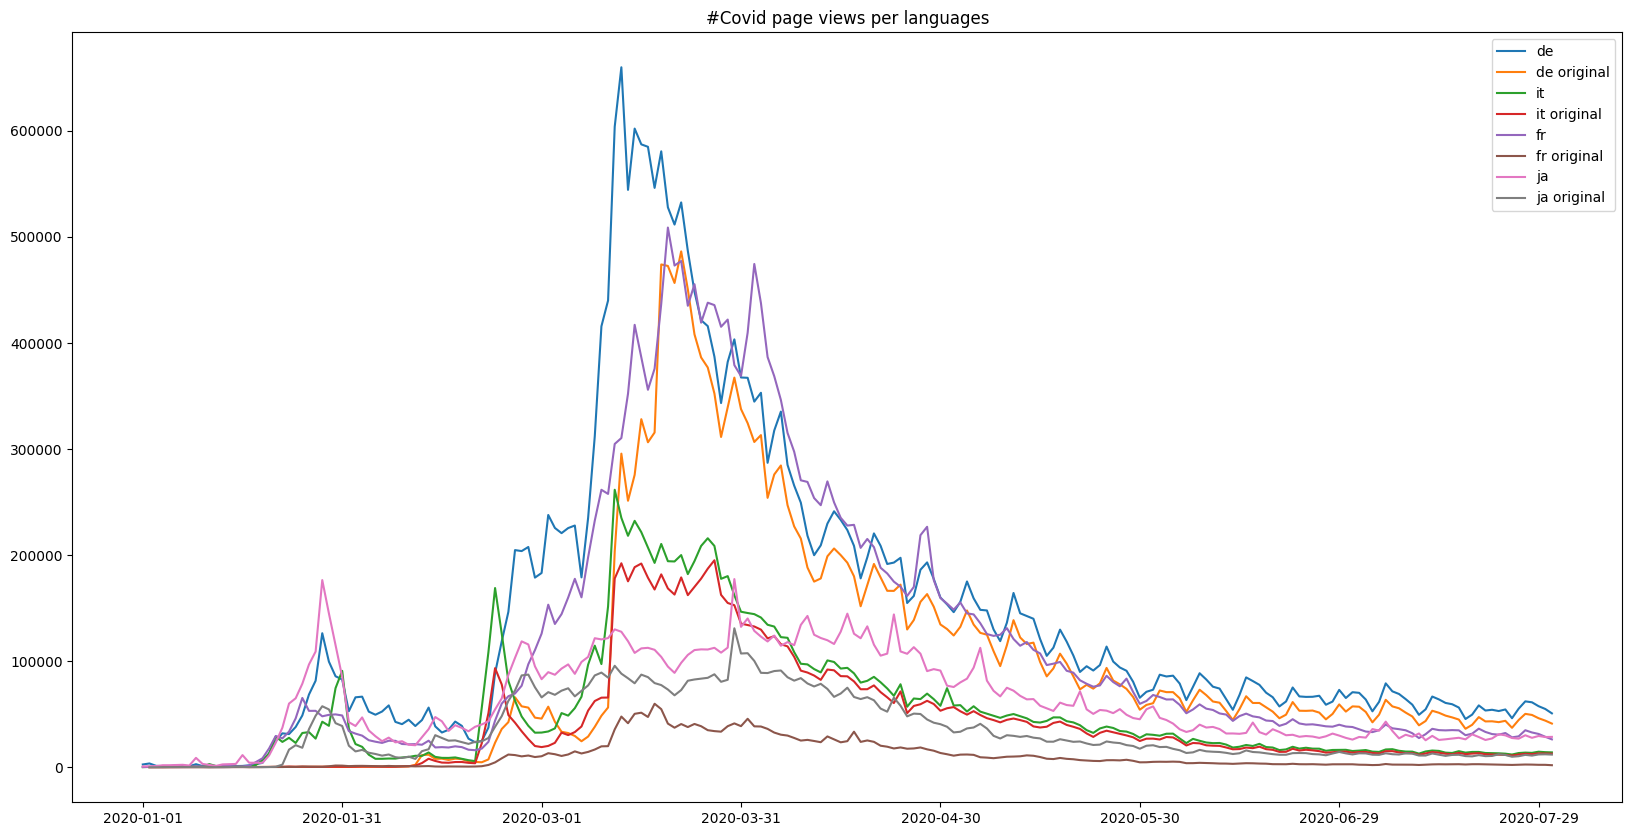

In [13]:
plt.figure(figsize=(20, 10))
#load original aggregated page views
agg = load_aggregated("data/aggregated_timeseries.json.gz")
df_agg = pd.DataFrame.from_dict(agg)
#load intervention in different countries
interventions = pd.read_csv('data/interventions.csv')
#removing english and catalan
interventions = interventions.drop(interventions[interventions['lang']=='en'].index).drop(interventions[interventions['lang']=='ca'].index)
df_covid_agg = pd.DataFrame()
df_newM  = pd.DataFrame()
lang = []
#we considered only 4 language to compare with the new implementation
countries = ["de", "it", "fr", "ja"]
for value in countries:
    #extract page views using new method
    df_newM = wiki_to_df_extract(value, '20200101', '20200731').rename({'views': value}, axis='columns')
    df_newM['date'] = df_newM.index
    df_newM['date'] = df_newM['date'].apply(lambda s: pd.to_datetime(s[:8], format='%Y%m%d'))
    df_newM = df_newM.set_index('date')

    #Plot the evolution of the number of pages search per language
    plt.plot(df_newM[value], label=str(value))
    #extract page views using old method
    df_oldM = pd.DataFrame.from_dict(df_agg[value]['covid']) + pd.DataFrame.from_dict(df_agg[value + ".m"]['covid'])
    df_oldM = df_oldM.loc[df_oldM.index > '2020-01-01'].drop(['percent', 'len'], axis= 1)
    #Plot the evolution of the number of pages search per language
    plt.plot(df_oldM, label=str(value) + " original")
    #df_covid_agg = pd.concat([df_covid_agg, df_tmp], axis= 1)
plt.legend()
plt.title("#Covid page views per languages")
skip = 30 #To show only the date on x-axis every month
plt.xticks(df_newM.index[::skip])
plt.show()

In the plot "#Covid page views per languages", we can see that the original dataset underestimate the number of covid-related page views for each language. For example, for japanese our new method of extraction curve is only an offset of the original curve, however for french, it is a completly different curve which make more sense considering other languages with similar population of native speaker (german). The tendancies stay similar between each method, thus we can confirm the relevance of this new method that we will use for the rest of the project.